# Concatenation

With {func}`treedata.concat`, {class}`treedata.TreeData` objects can be combined via a composition of two operations: concatenation and merging.

Concatenation is when we keep all sub elements of each object, and stack these elements in an ordered way.

Merging is combining a set of collections into one resulting collection which contains elements from the objects.

This logic is identical to {func}`anndata.concat` so you should check out the the anndata concatenation [tutorial](https://anndata.readthedocs.io/en/latest/concatenation.html) to understand the basics. This tutorial will focus on how the `obst` and `vart` fields in `TreeData` objects are handled during concatenation and merging.

In [35]:
import networkx as nx
import numpy as np
import pandas as pd
import treedata as td
import matplotlib.pyplot as plt

In [36]:
def plot_tree(tree, color_attr=None):
    """Helper function for plotting trees."""
    plt.figure(figsize=(6, 3))
    node_colors = "lightgrey" if color_attr is None else [tree.nodes[node].get(color_attr) for node in tree.nodes()]
    pos = nx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")
    nx.draw(tree, pos, with_labels=False, node_size=100, node_color=node_colors)
    leaf_nodes = [node for node in tree.nodes() if tree.out_degree(node) == 0]
    for node, (x, y) in pos.items():
        if node in leaf_nodes:
            plt.text(x, y + 10, s=node, rotation=90, fontsize=6, ha="center", va="top")
        else:
            plt.text(x, y, s=node, fontsize=6, ha="center", va="center")
    plt.show()

## Concatenation

Let's start by creating a `TreeData` object with 32 observations and 32 variables with a tree aligned to each axis.

In [37]:
counts = pd.DataFrame(
    np.random.normal(size=(32, 32)),
    index=[f"Obs_{i:d}" for i in range(32)],
    columns=[f"Var_{i:d}" for i in range(32)],
)
tree = nx.balanced_tree(r=2, h=5, create_using=nx.DiGraph)
leaves = [i for i in tree.nodes if tree.out_degree(i) == 0]
obs_tree = nx.relabel_nodes(tree, {j: f"Obs_{i}" for i, j in enumerate(leaves)})
var_tree = nx.relabel_nodes(tree, {j: f"Var_{i}" for i, j in enumerate(leaves)})
tdata = td.TreeData(counts, obst={"tree": obs_tree}, vart={"tree": var_tree}, label=None)

When we split the the `TreeData` along the observations axis, each tree in `obst` is a subtree of the original `obst` value while each tree in `vart` remains unchanged.

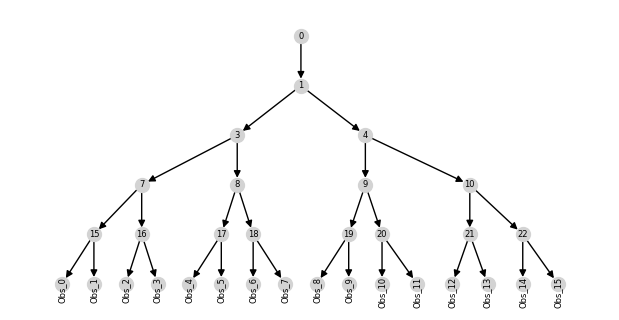

View of TreeData object with n_obs × n_vars = 16 × 32
    obst: 'tree'
    vart: 'tree'

In [38]:
tdata1 = tdata[:16]
tdata2 = tdata[16:]
plot_tree(tdata1.obst["tree"])
tdata1

If we then concatenate the two `TreeData` objects along the observations axis, each tree in the `obst` field is generated by combining the trees with that key. In this case, it is the original tree since we have not modified any of the `obst` values.

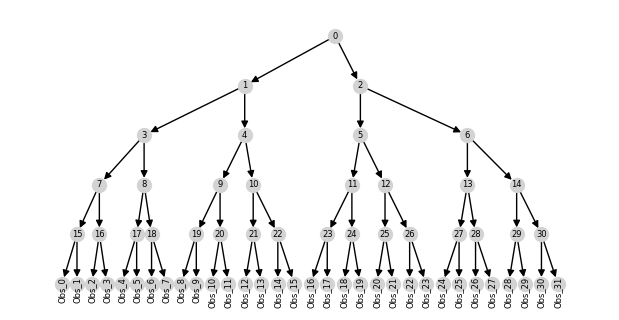

TreeData object with n_obs × n_vars = 32 × 32
    obst: 'tree'

In [39]:
tdata_concat = td.concat([tdata1, tdata2], axis=0)
plot_tree(tdata_concat.obst["tree"])
tdata_concat

But if we were to remove the observation tree in `tdata1`, the tree in the concatenated `obst` field would be the tree in `tdata2`.

/tmp/ipykernel_2077019/2280984650.py:1: UserWarning: Removing element `.obst['tree']` of view, initializing view as actual.
  del tdata1.obst["tree"]


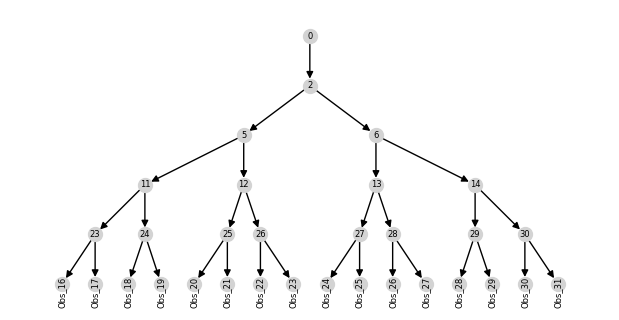

TreeData object with n_obs × n_vars = 32 × 16
    obst: 'tree'

In [75]:
del tdata1.obst["tree"]
tdata_concat = td.concat([tdata1, tdata2], axis=0)
plot_tree(tdata_concat.obst["tree"])
tdata_concat

You may have noticed that there is no tree in the `vart` field of the concatenated `TreeData` object which leads us to an explanation of the merging operation.

## Merging

Combining elements not aligned to the axis of concatenation is controlled through the `merge` argument. We provide a few strategies for merging elements aligned to the alternative axes:

`None`: No elements aligned to alternative axes are present in the result object.

`"same"`: Elements that are the same in each of the objects.

`"unique"`: Elements for which there is only one possible value.

`"first"`: The first element seen in each from each position.

`"only"`: Elements that show up in only one of the objects.

The default `merge` strategy is `None` which is why the `vart` field is empty in the concatenated `TreeData` object. 

In [77]:
tdata1 = tdata[:16]
tdata2 = tdata[16:]
tdata_concat = td.concat([tdata1, tdata2], axis=0)
tdata_concat

TreeData object with n_obs × n_vars = 32 × 32
    obst: 'tree'

But if we set `merge="same"`, the `vart` field will contain the tree since `tdata1.vart['tree']` and `tdata2.vart['tree']` are the same.

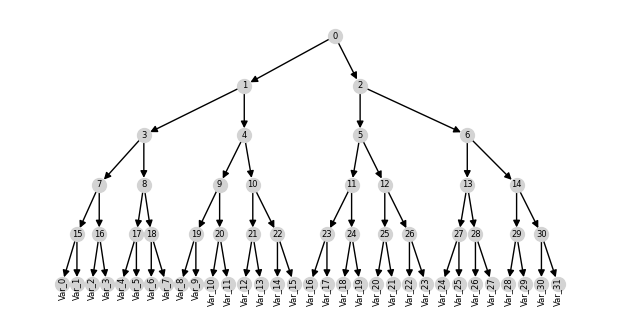

TreeData object with n_obs × n_vars = 32 × 32
    obst: 'tree'
    vart: 'tree'

In [78]:
tdata_concat = td.concat([tdata1, tdata2], axis=0, merge="same")
plot_tree(tdata_concat.vart["tree"])
tdata_concat

Alternatively, if the trees were not the same, we could set `merge="first"` to keep the tree in `tdata1.vart['tree']`.

/tmp/ipykernel_2077019/3779025952.py:1: UserWarning: Setting element `.vart['tree']` of view, initializing view as actual.
  tdata1.vart["tree"] = nx.relabel_nodes(tdata1.vart["tree"],{0: "root"})


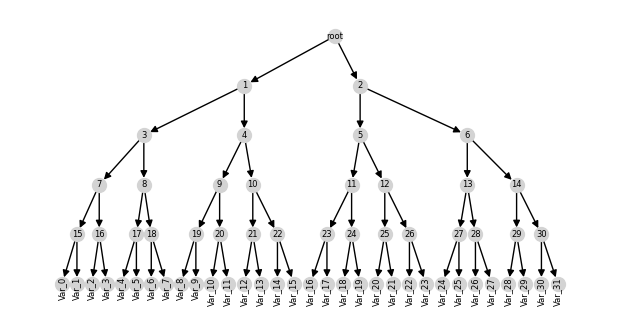

TreeData object with n_obs × n_vars = 32 × 32
    obst: 'tree'
    vart: 'tree'

In [79]:
tdata1.vart["tree"] = nx.relabel_nodes(tdata1.vart["tree"], {0: "root"})
tdata_concat = td.concat([tdata1, tdata2], axis=0, merge="first")
plot_tree(tdata_concat.vart["tree"])
tdata_concat

## Inner and outer joins

When the variables present in the objects to be concatenated aren’t exactly the same, you can choose to take either the intersection or union of these variables. This is otherwise called taking the `"inner"` (intersection) or `"outer"` (union) join. For example, given two `TreeData` objects with differing variables:

In [84]:
tdata1 = tdata[:16, :24]
tdata2 = tdata[16:, 8:]
print("tdata1 var_names", tdata1.var_names)
print("tdata2 var_names", tdata2.var_names)

tdata1 var_names Index(['Var_0', 'Var_1', 'Var_2', 'Var_3', 'Var_4', 'Var_5', 'Var_6', 'Var_7',
       'Var_8', 'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14',
       'Var_15', 'Var_16', 'Var_17', 'Var_18', 'Var_19', 'Var_20', 'Var_21',
       'Var_22', 'Var_23'],
      dtype='object')
tdata2 var_names Index(['Var_8', 'Var_9', 'Var_10', 'Var_11', 'Var_12', 'Var_13', 'Var_14',
       'Var_15', 'Var_16', 'Var_17', 'Var_18', 'Var_19', 'Var_20', 'Var_21',
       'Var_22', 'Var_23', 'Var_24', 'Var_25', 'Var_26', 'Var_27', 'Var_28',
       'Var_29', 'Var_30', 'Var_31'],
      dtype='object')


When `join="inner"` and `merge="first"`, the resulting `TreeData` object will contain only the variables present in both objects and the `vart` field will contain the tree from `tdata1` subset to this set of variables.

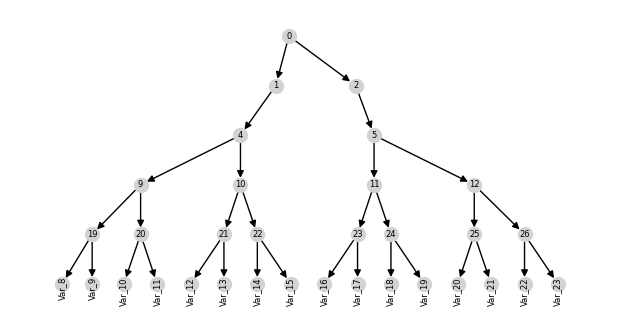

TreeData object with n_obs × n_vars = 32 × 16
    obst: 'tree'
    vart: 'tree'

In [81]:
tdata_inner = td.concat([tdata1, tdata2], axis=0, join="inner", merge="first")
plot_tree(tdata_inner.vart["tree"])
tdata_inner

When join="outer" and merge="first", the resulting `TreeData` object will contain all variables present in either object and the `vart` field will contain the tree from `tdata1`.

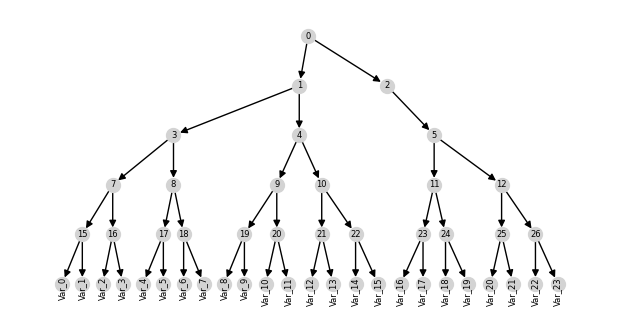

TreeData object with n_obs × n_vars = 32 × 32
    obst: 'tree'
    vart: 'tree'

In [82]:
tdata_outer = td.concat([tdata1, tdata2], axis=0, join="outer", merge="first")
plot_tree(tdata_outer.vart["tree"])
tdata_outer

As you can see trees are not combined along the alternate axis during concatenation. If you wish to combine trees along a particular axis, you need to specify it as the concatenation axis. For example, if you want to combine `vart` trees, you should concatenate along the variables axis (`axis = 1`).